# Poles2025 quick look

In [ ]:
# Ensure notebook root directory is correct
from pathlib import Path
import random
import sys

# Normalize project root whether notebook is run from repo root or notebooks/
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import cv2

from src import data
from src.config import Paths


main_root = PROJECT_ROOT / "Poles2025/roadpoles_v1"
iphone_root = PROJECT_ROOT / "Poles2025/Road_poles_iPhone"
paths = Paths(dataset_root=main_root)

main_root, iphone_root


(PosixPath('/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1'),
 PosixPath('/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/Road_poles_iPhone'))

In [4]:
# Split-level overview (roadpoles_v1)
summary_main = data.split_summary(main_root)
summary_main

,split,num_label_files,num_images
0,train,322,322
1,valid,92,92
2,test,0,46


In [5]:
# Split overview for Road_poles_iPhone (counts from file lists)
iphone_lists = {
    "train": iphone_root / "Train.txt",
    "valid": iphone_root / "Validation.txt",
    "test": iphone_root / "Test.txt",
}

def _count_lines(p: Path) -> int:
    with open(p, "r", encoding="utf-8") as f:
        return sum(1 for _ in f)

summary_iphone = pd.DataFrame(
    [
        {"split": split, "num_images": _count_lines(path), "num_label_files": _count_lines(path)}
        for split, path in iphone_lists.items()
    ]
)
summary_iphone

,split,num_images,num_label_files
0,train,942,942
1,valid,261,261
2,test,138,138


In [6]:
# Load annotations into unified DataFrames
df_main = data.load_annotations("train", main_root)
df_iphone = data.load_annotations_from_filelist(
    iphone_root / "Train.txt",
    dataset_root=iphone_root,
    images_dirname="images",
    labels_dirname="labels",
)

df_main.head(), df_iphone.head()

(                                          image_path  \
 0  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   
 1  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   
 2  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   
 3  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   
 4  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   
 
                                           label_path  class_id        cx  \
 0  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...         0  0.685167   
 1  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...         0  0.182656   
 2  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...         0  0.138922   
 3  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...         0  0.709982   
 4  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...         0  0.079453   
 
          cy         w         h  
 0  0.576954  0.013979  0.085828  
 1  0.596896  0.006250  0.081705  
 2  0.602053  0.005698  0.093659  
 3  0.577786  0.016078  0.100273  
 4  0.610099  0.0

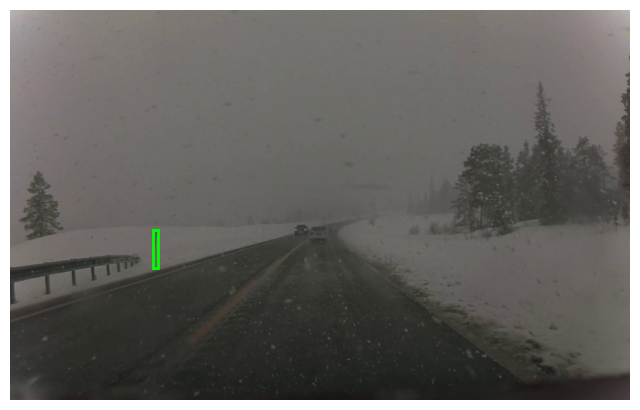

In [7]:
# Visualize one random training image with boxes (roadpoles_v1)
sample_image = random.choice(df_main["image_path"].dropna().tolist())
sample_labels = df_main[df_main["image_path"] == sample_image]

img = plt.imread(sample_image)
h, w = img.shape[:2]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)

for _, row in sample_labels.iterrows():
    cx, cy, bw, bh = row[["cx", "cy", "w", "h"]]
    cx *= w
    cy *= h
    bw *= w
    bh *= h
    x0 = cx - bw / 2
    y0 = cy - bh / 2
    rect = plt.Rectangle((x0, y0), bw, bh, linewidth=2, edgecolor="lime", facecolor="none")
    ax.add_patch(rect)

ax.set_axis_off()
plt.show()

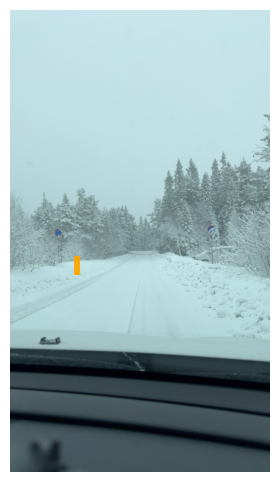

In [142]:
# Visualize one random training image with boxes (Road_poles_iPhone)
sample_image_iphone = random.choice(df_iphone["image_path"].dropna().tolist())
sample_labels_iphone = df_iphone[df_iphone["image_path"] == sample_image_iphone]

img = plt.imread(sample_image_iphone)
h, w = img.shape[:2]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)

for _, row in sample_labels_iphone.iterrows():
    cx, cy, bw, bh = row[["cx", "cy", "w", "h"]]
    cx *= w
    cy *= h
    bw *= w
    bh *= h
    x0 = cx - bw / 2
    y0 = cy - bh / 2
    rect = plt.Rectangle((x0, y0), bw, bh, linewidth=2, edgecolor="orange", facecolor="none")
    ax.add_patch(rect)

ax.set_axis_off()
plt.show()

## Geometry: box size, aspect, placement

In [9]:
# Add geometry columns (relative area, aspect ratio)
df_main_geom = df_main.copy()
df_main_geom["area"] = df_main_geom["w"] * df_main_geom["h"]
df_main_geom["aspect"] = df_main_geom["w"] / df_main_geom["h"]

df_iphone_geom = df_iphone.copy()
df_iphone_geom["area"] = df_iphone_geom["w"] * df_iphone_geom["h"]
df_iphone_geom["aspect"] = df_iphone_geom["w"] / df_iphone_geom["h"]

df_main_geom[["area", "aspect"]].describe(), df_iphone_geom[["area", "aspect"]].describe()

(             area      aspect
 count  392.000000  392.000000
 mean     0.001542    0.074923
 std      0.002945    0.037469
 min      0.000153    0.016904
 25%      0.000374    0.050979
 50%      0.000609    0.066687
 75%      0.001286    0.086152
 max      0.026105    0.240638,
               area       aspect
 count  1169.000000  1169.000000
 mean      0.001078     0.356601
 std       0.000954     0.247084
 min       0.000075     0.044693
 25%       0.000496     0.190190
 50%       0.000778     0.310663
 75%       0.001316     0.463725
 max       0.010007     2.581307)

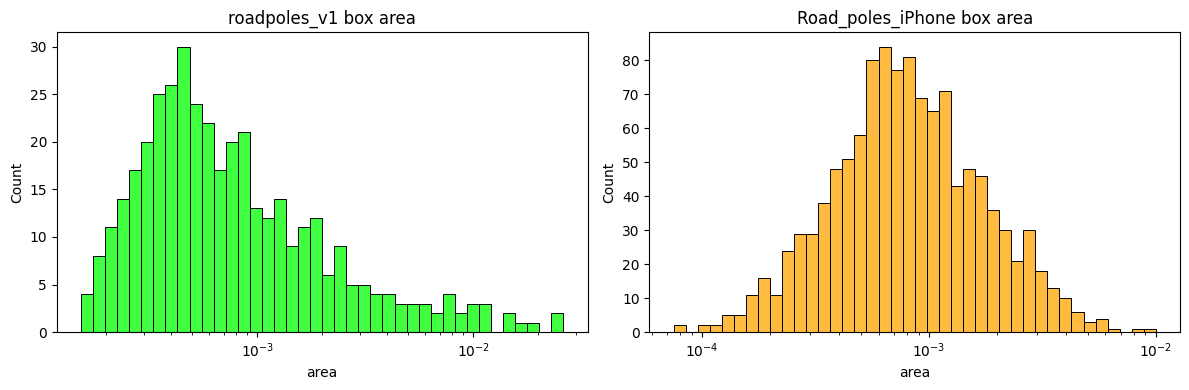

In [10]:
# Box area distributions (log scale)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_main_geom["area"], bins=40, ax=axes[0], log_scale=True, color="lime")
axes[0].set_title("roadpoles_v1 box area")
sns.histplot(df_iphone_geom["area"], bins=40, ax=axes[1], log_scale=True, color="orange")
axes[1].set_title("Road_poles_iPhone box area")
plt.tight_layout()
plt.show()

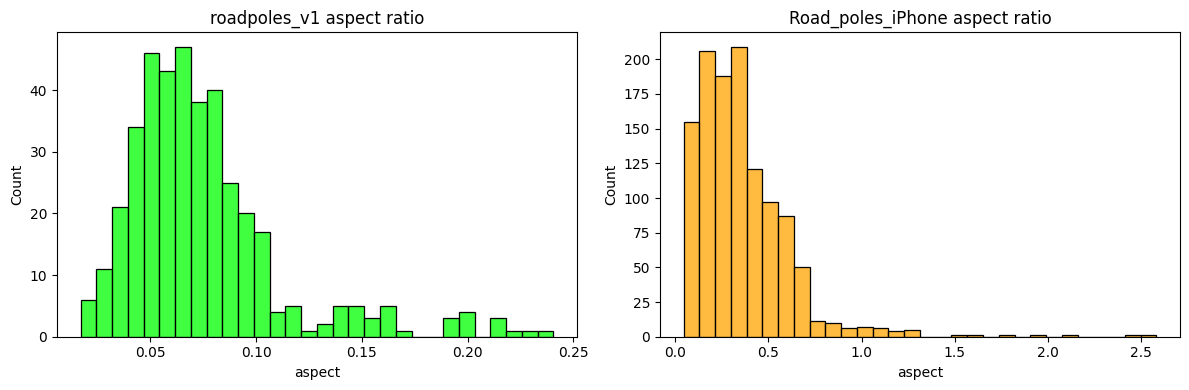

In [11]:
# Aspect ratio distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_main_geom["aspect"], bins=30, ax=axes[0], color="lime")
axes[0].set_title("roadpoles_v1 aspect ratio")
sns.histplot(df_iphone_geom["aspect"], bins=30, ax=axes[1], color="orange")
axes[1].set_title("Road_poles_iPhone aspect ratio")
plt.tight_layout()
plt.show()

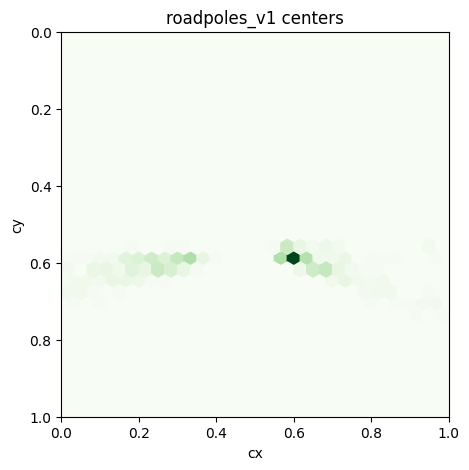

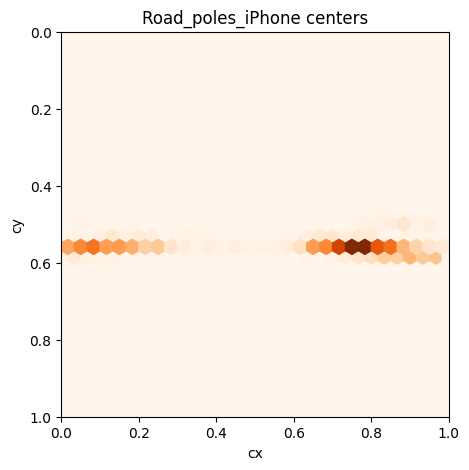

In [12]:
# Center heatmaps to see spatial bias
def plot_center_heatmap(df, title, color):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hexbin(df["cx"], df["cy"], gridsize=30, cmap=color, extent=(0,1,0,1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("cx")
    ax.set_ylabel("cy")
    plt.gca().invert_yaxis()
    plt.show()

plot_center_heatmap(df_main_geom, "roadpoles_v1 centers", "Greens")
plot_center_heatmap(df_iphone_geom, "Road_poles_iPhone centers", "Oranges")

## Quality/conditions: brightness, contrast, blur

In [13]:
def compute_image_stats(df, max_samples=200):
    # Sample unique images to keep it quick
    unique_imgs = list(dict.fromkeys(df["image_path"].dropna().tolist()))
    random.shuffle(unique_imgs)
    imgs = unique_imgs[:max_samples]
    rows = []
    for img_path in imgs:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mean = float(gray.mean())
        std = float(gray.std())
        blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())
        rows.append({"image_path": img_path, "brightness": mean, "contrast": std, "blur": blur})
    return pd.DataFrame(rows)

stats_main = compute_image_stats(df_main, max_samples=300)
stats_iphone = compute_image_stats(df_iphone, max_samples=300)
stats_main.head(), stats_iphone.head()

(                                          image_path  brightness   contrast  \
 0  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   87.671813  28.976434   
 1  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   88.073778  29.263315   
 2  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   87.189191  28.847154   
 3  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   96.608893  38.123060   
 4  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...   95.959931  35.926582   
 
         blur  
 0   6.589598  
 1   7.462970  
 2   5.293424  
 3  32.396494  
 4  17.652301  ,
                                           image_path  brightness   contrast  \
 0  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  153.368274  65.659108   
 1  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  152.210592  70.345916   
 2  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  157.588582  67.491411   
 3  /home/erikhbj/Documents/tdt17/TDT17-snow-pole-...  143.379581  68.116746   
 4  /home/erikhbj/Doc

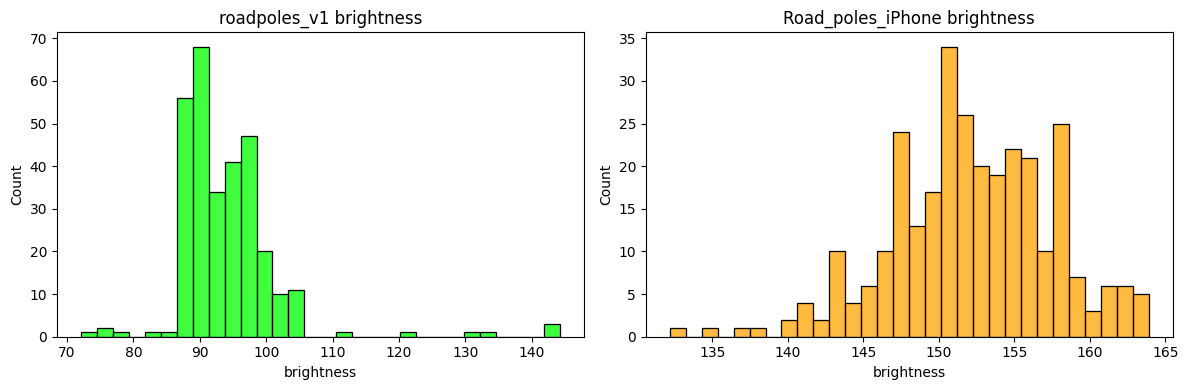

In [14]:
# Brightness distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(stats_main["brightness"], bins=30, ax=axes[0], color="lime")
axes[0].set_title("roadpoles_v1 brightness")
sns.histplot(stats_iphone["brightness"], bins=30, ax=axes[1], color="orange")
axes[1].set_title("Road_poles_iPhone brightness")
plt.tight_layout()
plt.show()

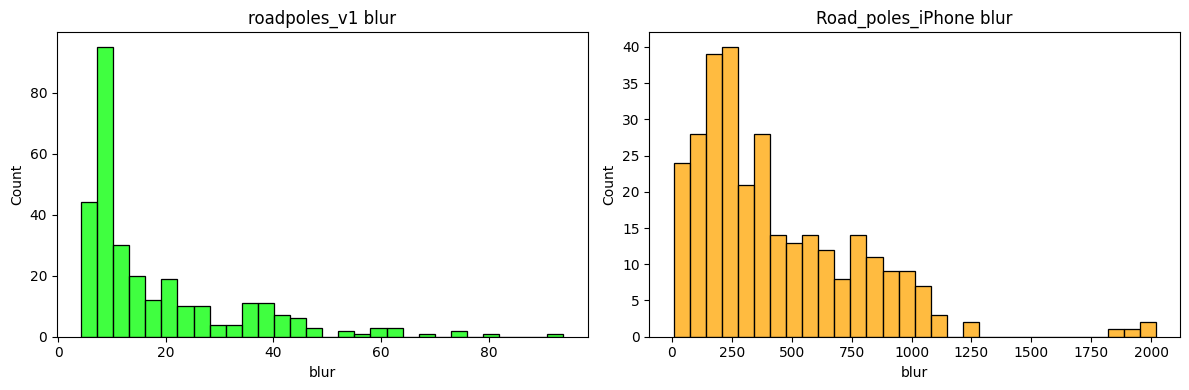

In [15]:
# Blur (variance of Laplacian)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(stats_main["blur"], bins=30, ax=axes[0], color="lime")
axes[0].set_title("roadpoles_v1 blur")
sns.histplot(stats_iphone["blur"], bins=30, ax=axes[1], color="orange")
axes[1].set_title("Road_poles_iPhone blur")
plt.tight_layout()
plt.show()

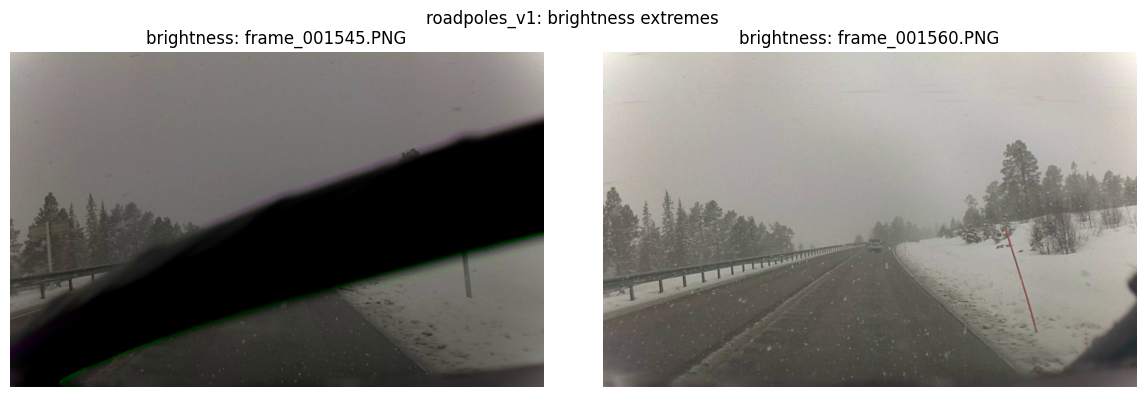

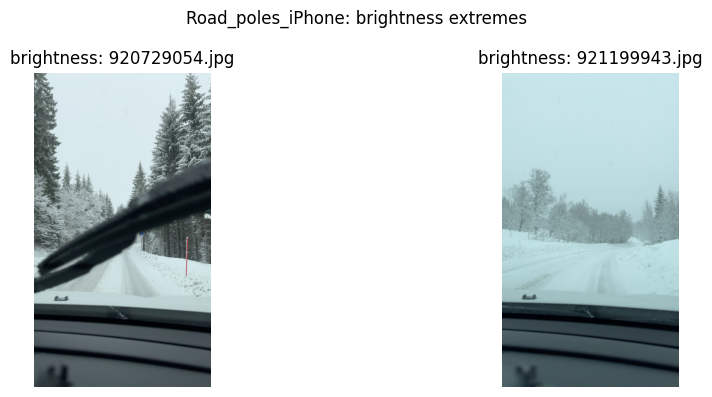

In [16]:
# Quick look at extreme cases (darkest, brightest, blurriest)
def show_extremes(stats_df, title_prefix, metric):
    if stats_df.empty:
        return
    sorted_df = stats_df.sort_values(metric)
    sample_paths = list(sorted_df.head(1)["image_path"]) + list(sorted_df.tail(1)["image_path"])
    fig, axes = plt.subplots(1, len(sample_paths), figsize=(12, 4))
    for ax, path in zip(axes, sample_paths):
        img = plt.imread(path)
        ax.imshow(img)
        ax.set_title(f"{metric}: {path.name}")
        ax.axis('off')
    fig.suptitle(f"{title_prefix}: {metric} extremes")
    plt.tight_layout()
    plt.show()

show_extremes(stats_main, "roadpoles_v1", "brightness")
show_extremes(stats_iphone, "Road_poles_iPhone", "brightness")